# LLM Homework Solutions

### HW1 problem 2

I used Claude 3.7 Sonnet. My inputs were a screenshot of the problem statement, and a PDF of Hernquist 1990. My prompt was: "Solve the problem in the image I sent using Python code. The problem statement mentions a paper (Hernquist 1990). I have attached the pdf here."

1. The first attempt took less than a minute to complete. After the first attempt, a projection error occured, where an array was input when a scalar was expected based on the way a function was written. I simply pasted in the error, and the code was changed.

2. The second attempt took multiple minutes to complete. It made several edits to the original code. The code then successfully output a plot, but it did not show any data lines, only a theoretical line that did not make sense. There were also multiple errors with square roots of negatives. I ran out of message length on my first conversation, so I copied the code over to a new chat, along with the problem statement and a screenshot of the current output. My new prompt was: "I have attached the problem statement here, along with an image of the current output of the code. Fix the code below to solve the problem. Specifically the square root issues and the plot."

3. It failed miserably. I had to switch to ChatGPT because I ran out of free Claude messages for the day.

4. I once again had to switch, ChatGPT just put out things with errors, and I ran out of free inputs again.

5. I put in the following prompt to Gemini and got the code below. I have no more prompts for Gemini. As you can see, I had to put in my own thought process and the starting code that I used for the original solution I wrote:

"Solve the attached problem. I will give you some starting point code, and below are some hints based on a successful solution's thought process for the next steps. Think very carefully, read through this code and these comments thoroughly, and craft expert code that solves this problem the right way.

*code attached*

"I can now define the various other needed functions, including a 1-variable distribution function for our specific halo, its integral, this halos total distribution function including the density of states, and my bounding function. Now I define a table of energies across the spectrum we will need, and I calculate a tabulated CDF of the distribution function to be used for inversion later. Now I can check the bounding function's validity, choosing a random middling radius (r_test) to plot the Hernquist distribution and the bounding function I chose, in order to check that it truly envelopes the distribution, as expected. Here is the script for sampling the energies by looping through the radii. I essentially invert the CDF by using the lookup table I created before. Then I cut things off at the max energy for that radius and select a random CDF value and find the corresponding energy. Then I choose a random value under the curve of the bounding function at that energy, reject it if it is over the Hernquist PDF and accept it if it is under. Now I can make my velocities into 3-vectors. I do this the exact same way as was done with the positions. Lastly I will check against the velocity dispersion given in Hernquist's 1990 paper. I define the theory function and create plottable arrays from it. Then I do a dot product to find the v_r components of each velocity, and bin them. I use binned_statistics from scipy.stats to compute the sdev of each bin, and then use the bin centers for plotting purposes.""

In [50]:
# Generate random numbers for cumulative mass fraction
# Avoid X=1 which gives r=inf. Use rand() which is [0, 1)
rand_X = my_randState.rand(N_particles)

# Calculate radii in simulation units (a=1)
# Protect against division by zero if rand_X is very close to 1 (unlikely for N=1e6)
sqrtX = np.sqrt(rand_X)
rvals_sim = a_sim * sqrtX / (1.0 - sqrtX)
rvals_sim = np.sort(rvals_sim) # Sorting is optional but done in snippet

# Generate random spherical angles
rand_angles = my_randState.rand(2, N_particles)
phi = 2.0 * np.pi * rand_angles[0]
# Correct formula for theta to sample uniformly on sphere: cos(theta) uniform in [-1, 1]
cos_theta = 1.0 - 2.0 * rand_angles[1] # Uniform in [-1, 1]
sin_theta = np.sqrt(1.0 - cos_theta**2)

# Initialize 3D position array (simulation units)
pos_sim = np.zeros((N_particles, 3), dtype='float32')

# Calculate Cartesian coordinates
pos_sim[:, 0] = rvals_sim * sin_theta * np.cos(phi)
pos_sim[:, 1] = rvals_sim * sin_theta * np.sin(phi)
pos_sim[:, 2] = rvals_sim * cos_theta

# Store radii for later use
# Recalculate just in case, ensures consistency
rvals_sim = np.linalg.norm(pos_sim, axis=1)

print(f"Generated {N_particles} positions.")
print(f"Sample radii (sim units): {rvals_sim[:5]}")
print(f"Max radius (sim units): {rvals_sim.max():.2f}")

# Convert positions and radii to physical units for potential later use/plotting
rvals_phys = rvals_sim * a_phys
pos_phys = pos_sim * a_phys

Generated 1000000 positions.
Sample radii (sim units): [0.00070751 0.00122225 0.00131322 0.0015517  0.00203405]
Max radius (sim units): 27891642.00


In [51]:
# Hernquist Potential in Simulation Units (G=1, M=1, a=1)
def potential_hernquist(r, G=G_sim, M=M_sim, a=a_sim):
    """ Calculates Hernquist potential Phi(r) = -GM / (r + a). """
    return - G * M / (r + a)

# Hernquist Distribution Function f(E) in Simulation Units (G=1, M=1, a=1)
# From Hernquist (1990), Eq. 17
def f_hernquist(E, G=G_sim, M=M_sim, a=a_sim):
    """ Calculates Hernquist distribution function f(E).
        Assumes E is negative (bound orbits).
        Uses simulation units (G=1, M=1, a=1).
    """
    if np.any(E >= 0):
         # Handle cases E>=0 where f(E) is not defined or is 0
         # For safety, return 0 or raise error. Let's return 0.
         if isinstance(E, np.ndarray):
             res = np.zeros_like(E, dtype=float)
             mask = E < 0
             if np.any(mask):
                 res[mask] = f_hernquist(E[mask], G, M, a)
             return res
         else: # Scalar E
             if E >= 0: return 0.0
             # continue for scalar E < 0

    # Characteristic velocity squared v_c^2 = GM/a
    vc_sq = G * M / a # This is 1.0 in simulation units

    # q = sqrt(-E / v_c^2) = sqrt(-E) in sim units
    q = np.sqrt(-E / vc_sq)

    # Handle q -> 1 limit (E -> -vc_sq = -1) numerically if necessary
    # Add a small epsilon to avoid q=1 directly if it causes issues
    epsilon = 1e-9
    q = np.minimum(q, 1.0 - epsilon)

    # Avoid domain errors for arcsin and sqrt
    if np.any(q < 0) or np.any(q > 1):
        raise ValueError("q must be between 0 and 1")

    term1 = 1.0 / (1.0 - q**2)**(2.5)
    term2_arcsin = 3.0 * np.arcsin(q)
    sqrt_1_q2 = np.sqrt(1.0 - q**2)
    term2_poly = q * sqrt_1_q2 * (1.0 - 2.0*q**2) * (8.0*q**4 - 8.0*q**2 - 3.0)
    term2 = term2_arcsin + term2_poly

    # Prefactor: M / (8 * sqrt(2) * pi^3 * (GM a)^3/2 )
    # In sim units: 1 / (8 * sqrt(2) * pi^3)
    prefactor = M / (8.0 * np.sqrt(2.0) * np.pi**3 * (G*M*a)**1.5) # M=1,G=1,a=1 -> 1/(...)

    # Check for invalid values (e.g., NaN resulting from q near 1)
    result = prefactor * term1 * term2
    if isinstance(result, np.ndarray):
        result[np.isnan(result)] = 0 # Set NaN results (e.g. if q was exactly 1) to 0
    elif np.isnan(result):
        result = 0.0

    return result

In [52]:
# Define the function proportional to p(E|r) to integrate for CDF
def prob_E_given_r_integrand(E, r, G=G_sim, M=M_sim, a=a_sim):
    """ Calculates the unnormalized probability density integrand: f(E) * sqrt(E - Phi(r)).
        Returns 0 if E < Phi(r).
    """
    phi_r = potential_hernquist(r, G, M, a)
    if isinstance(E, np.ndarray):
        integrand = np.zeros_like(E, dtype=float)
        valid_mask = E > phi_r
        E_valid = E[valid_mask]
        if E_valid.size > 0:
            f_val = f_hernquist(E_valid, G, M, a)
            sqrt_term = np.sqrt(E_valid - phi_r)
            integrand[valid_mask] = f_val * sqrt_term
        return integrand
    else: # Scalar E
        if E <= phi_r:
            return 0.0
        f_val = f_hernquist(E, G, M, a)
        sqrt_term = np.sqrt(E - phi_r)
        return f_val * sqrt_term

# --- Precompute CDF Table ---
print("Precomputing CDF table for energy sampling...")

# Define grid for radius and energy (in simulation units)
# Use log spacing for radius as density profile varies over orders of magnitude
n_radius_bins = 100
# Max radius could be determined by particle data, or set reasonably large
# Add a small value to min to avoid r=0 issues if needed
r_grid_min = max(rvals_sim.min() * 0.5, a_sim * 1e-4)
r_grid_max = rvals_sim.max() * 1.1
r_grid = np.geomspace(r_grid_min, r_grid_max, n_radius_bins)

n_energy_bins = 200 # Number of points to define the CDF shape

# Store CDFs and corresponding Energy values
# Use lists first, then convert to arrays if needed, or use dict
cdf_tables = {} # Dictionary: r -> (E_vals, cdf_vals)

for r_val in r_grid:
    phi_r = potential_hernquist(r_val) # Minimum energy (most bound)
    E_max = 0.0 # Maximum energy (escape)

    # Create energy grid for this radius from Phi(r) to 0
    # Use linear or log spacing? Let's try linear first, maybe refine
    # Ensure E grid starts slightly above phi_r and ends slightly below 0
    E_vals_r = np.linspace(phi_r * (1.0 - 1e-6), E_max * (1.0 - 1e-9) - 1e-9 , n_energy_bins)

    # Calculate integrand values on the grid
    integrand_vals = prob_E_given_r_integrand(E_vals_r, r_val)

    # Ensure integrand is non-negative
    integrand_vals = np.maximum(integrand_vals, 0)

    # Calculate cumulative integral (CDF)
    # cumulative_trapezoid returns array N-1 long, prepend 0
    cdf_unnorm = cumulative_trapezoid(integrand_vals, E_vals_r, initial=0)

    # Normalize CDF
    total_integral = cdf_unnorm[-1]
    if total_integral > 1e-10: # Avoid division by zero if integral is negligible
        cdf_norm = cdf_unnorm / total_integral
    else:
        # If integral is zero (e.g., r very large), all particles have E~0, v~0
        cdf_norm = np.zeros_like(cdf_unnorm)
        # Or alternatively, set CDF to step function at E=0 if possible
        cdf_norm = np.linspace(0, 1, len(cdf_unnorm)) # Placeholder CDF

    # Store the energy grid and normalized CDF for this radius
    # Ensure CDF is monotonically increasing (due to numerical noise)
    cdf_norm = np.maximum.accumulate(cdf_norm)
    # Ensure CDF ends at 1.0
    cdf_norm /= cdf_norm[-1] if cdf_norm[-1] > 0 else 1.0

    cdf_tables[r_val] = (E_vals_r, cdf_norm)

print("CDF table computation complete.")

# Function to sample energy using the precomputed CDF table
def sample_energy_from_cdf(r, r_grid, cdf_tables, rand_state):
    """ Samples energy E for a given radius r using interpolated CDF. """
    # Find nearest radius in the grid (could interpolate between grids for more accuracy)
    r_nearest_idx = np.argmin(np.abs(r_grid - r))
    r_nearest = r_grid[r_nearest_idx]

    # Get the corresponding E grid and CDF
    E_vals, cdf_vals = cdf_tables[r_nearest]

    # Generate a uniform random number
    u = rand_state.rand()

    # Invert the CDF using interpolation
    # np.interp needs monotonically increasing xp (cdf_vals)
    # Need to handle cases where cdf_vals might not be strictly increasing due to numerics
    # Ensure uniqueness and monotonicity for interpolation
    unique_cdf, unique_idx = np.unique(cdf_vals, return_index=True)
    unique_E = E_vals[unique_idx]

    if len(unique_cdf) < 2:
        # Cannot interpolate, likely means distribution is a delta function (e.g., E=0)
        # Find the energy where CDF jumps
        if np.allclose(unique_cdf, 0.0): return E_vals[0] # All CDF is 0, return min E
        if np.allclose(unique_cdf, 1.0): return E_vals[-1] # All CDF is 1, return max E
        # Default to the mean E value if interpolation fails
        print(f"Warning: CDF interpolation failed for r={r:.2f}. Using mean E.")
        return np.mean(E_vals)


    # Interpolate E = CDF_inverse(u)
    E_sampled = np.interp(u, unique_cdf, unique_E)

    # Ensure the sampled energy is physically possible for the *actual* radius r
    phi_actual = potential_hernquist(r)
    E_sampled = np.clip(E_sampled, phi_actual, 0.0) # Clip E between Phi(r) and 0

    return E_sampled

Precomputing CDF table for energy sampling...
CDF table computation complete.


In [53]:
print("Sampling velocities...")

# Initialize velocity array (simulation units)
vel_sim = np.zeros((N_particles, 3), dtype='float32')

for i in range(N_particles):
    if (i + 1) % (N_particles // 10) == 0:
        print(f"  Processed {i+1}/{N_particles} particles...")

    r_i = rvals_sim[i]

    # Sample energy E for this particle based on its radius
    E_i = sample_energy_from_cdf(r_i, r_grid, cdf_tables, my_randState)

    # Calculate potential energy at r_i
    phi_i = potential_hernquist(r_i)

    # Calculate speed v = sqrt(2 * (E - Phi))
    # Ensure kinetic energy (E - Phi) is non-negative (should be by construction/clipping)
    kinetic_energy = max(0.0, E_i - phi_i)
    v_mag_i = np.sqrt(2.0 * kinetic_energy) # Speed in simulation units

    # Generate random direction for velocity vector (isotropic)
    # Using the same method as for positions
    rand_v_angles = my_randState.rand(2)
    v_phi = 2.0 * np.pi * rand_v_angles[0]
    v_cos_theta = 1.0 - 2.0 * rand_v_angles[1] # Uniform in [-1, 1]
    v_sin_theta = np.sqrt(max(0.0, 1.0 - v_cos_theta**2)) # Add max(0.0,..) for safety

    # Calculate velocity components
    vel_sim[i, 0] = v_mag_i * v_sin_theta * np.cos(v_phi)
    vel_sim[i, 1] = v_mag_i * v_sin_theta * np.sin(v_phi)
    vel_sim[i, 2] = v_mag_i * v_cos_theta

print("Velocity sampling complete.")

# Convert velocities to physical units (km/s)
vel_phys = vel_sim * V0_phys

print(f"Sample velocities (km/s): \n{vel_phys[:5,:]}")

Sampling velocities...
  Processed 100000/1000000 particles...
  Processed 200000/1000000 particles...
  Processed 300000/1000000 particles...
  Processed 400000/1000000 particles...
  Processed 500000/1000000 particles...
  Processed 600000/1000000 particles...
  Processed 700000/1000000 particles...
  Processed 800000/1000000 particles...
  Processed 900000/1000000 particles...
  Processed 1000000/1000000 particles...
Velocity sampling complete.
Sample velocities (km/s): 
[[ 17.28675     19.090109   -10.4700365 ]
 [ -1.6962346   33.68319      2.0825837 ]
 [  5.9252977   -4.031341    14.331608  ]
 [ -0.70885056 -18.522732     6.7315507 ]
 [-21.245096    38.728416    16.955393  ]]


<>:59: SyntaxWarning: invalid escape sequence '\s'

<>:60: SyntaxWarning: invalid escape sequence '\s'

<>:65: SyntaxWarning: invalid escape sequence '\s'

<>:59: SyntaxWarning: invalid escape sequence '\s'

<>:60: SyntaxWarning: invalid escape sequence '\s'

<>:65: SyntaxWarning: invalid escape sequence '\s'

/tmp/ipykernel_3446/3258623291.py:59: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(bin_centers, sigma_r_simulated, 'bo', label='Simulated $\sigma_r$', markersize=8)

/tmp/ipykernel_3446/3258623291.py:60: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(bin_centers, sigma_r_theory, 'r-', label='Theoretical $\sigma_r$ (Hernquist 1990)', linewidth=2)

/tmp/ipykernel_3446/3258623291.py:65: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('Radial Velocity Dispersion $\sigma_r$ (km/s)', fontsize=14)

Verifying results: Calculating radial velocity dispersion...


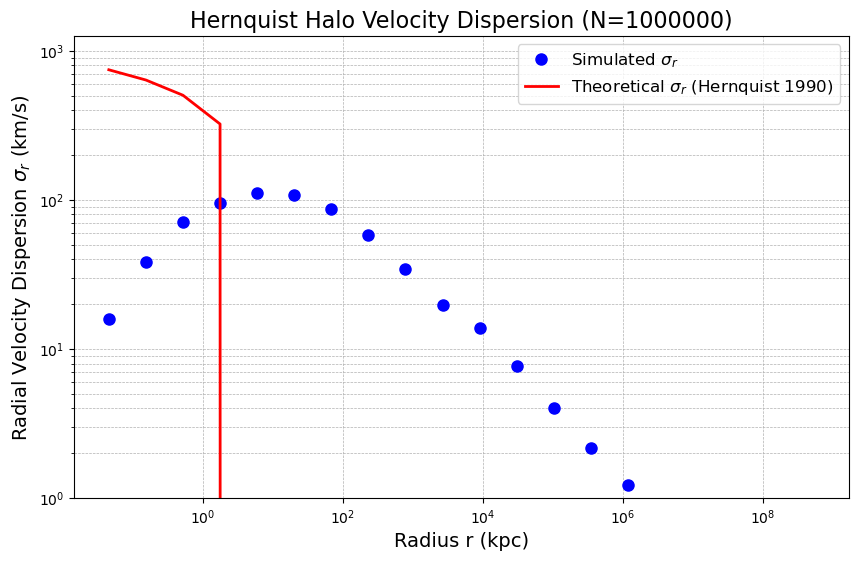

Verification plot generated.


In [54]:
print("Verifying results: Calculating radial velocity dispersion...")

# Calculate radial velocity component for each particle
# v_r = v . r_hat = (vx*x + vy*y + vz*z) / r
# Use simulation units for consistency check before scaling
# Avoid division by zero for particles exactly at r=0 (shouldn't happen with sampling method)
rvals_sim_safe = np.maximum(rvals_sim, 1e-9)
v_radial_sim = np.sum(vel_sim * pos_sim, axis=1) / rvals_sim_safe

# Bin particles by radius (use physical units for plotting)
n_bins_plot = 20
# Use log bins for radius
log_r_min = np.log10(max(rvals_phys.min(), 0.01)) # Avoid log(0)
log_r_max = np.log10(rvals_phys.max())
radius_bins = np.geomspace(10**log_r_min, 10**log_r_max, n_bins_plot + 1)

# Calculate mean square of v_radial in each bin (variance, since mean v_r is 0)
# Use physical velocities and radii now
v_radial_phys = v_radial_sim * V0_phys
mean_vr_sq, bin_edges, binnumber = binned_statistic(
    rvals_phys, v_radial_phys**2, statistic='mean', bins=radius_bins)

# Calculate standard deviation sigma_r = sqrt(<v_r^2>)
sigma_r_simulated = np.sqrt(mean_vr_sq)

# Get bin centers for plotting (use log scale for x-axis)
bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:]) # Geometric mean

# --- Theoretical Velocity Dispersion ---
def theoretical_vr_sq(r, G=G_phys, M=M_phys, a=a_phys):
    """ Calculates theoretical <v_r^2> from Hernquist (1990), Eq. 10 """
    x = r / a # Dimensionless radius r/a
    if isinstance(x, np.ndarray):
        x[x == 0] = 1e-9 # Avoid division by zero at r=0
    elif x == 0:
        x = 1e-9

    term1 = (G * M) / (12.0 * a)
    term2 = 1.0 / x
    term3 = (1.0 + x)**(-3.0)

    log_term = 12.0 * x * (1.0 + x) * np.log((x + 1.0) / x)
    poly_term = (x / (x + 1.0)) * (25.0 + 52.0*x + 42.0*x**2 + 12.0*x**3)

    vr_sq = term1 * term2 * term3 * (log_term - poly_term)
    # Ensure result is non-negative (can become slightly negative due to precision near r=0)
    if isinstance(vr_sq, np.ndarray):
        vr_sq[vr_sq < 0] = 0
    elif vr_sq < 0:
        vr_sq = 0

    return vr_sq

# Calculate theoretical sigma_r on the bin centers
sigma_r_theory = np.sqrt(theoretical_vr_sq(bin_centers, G=G_phys, M=M_phys, a=a_phys))

# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, sigma_r_simulated, 'bo', label='Simulated $\sigma_r$', markersize=8)
plt.plot(bin_centers, sigma_r_theory, 'r-', label='Theoretical $\sigma_r$ (Hernquist 1990)', linewidth=2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius r (kpc)', fontsize=14)
plt.ylabel('Radial Velocity Dispersion $\sigma_r$ (km/s)', fontsize=14)
plt.title(f'Hernquist Halo Velocity Dispersion (N={N_particles})', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(bottom=max(1, sigma_r_simulated[sigma_r_simulated > 0].min() * 0.5)) # Adjust y-limits
plt.show()

print("Verification plot generated.")

### HW2 problem 1:

1. First attempt, with ChatGPT with Reasoning turned on, and a screenshot of the problem included: "Solve the given problem in python. Think carefully, with an attention to detail, and use step by step logic and a deep understanding of RK formalism to solve the problem elegantly and correctly."

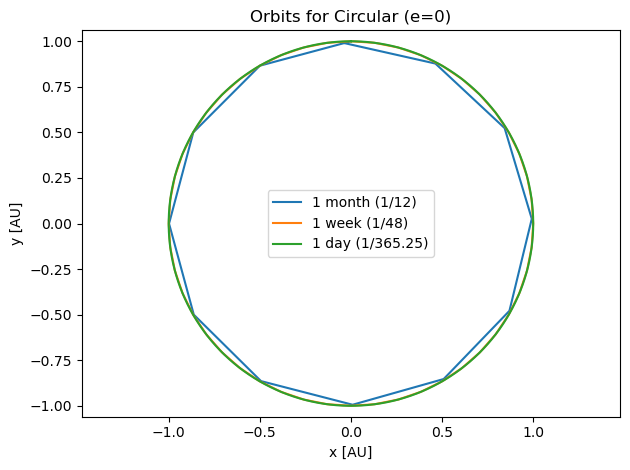

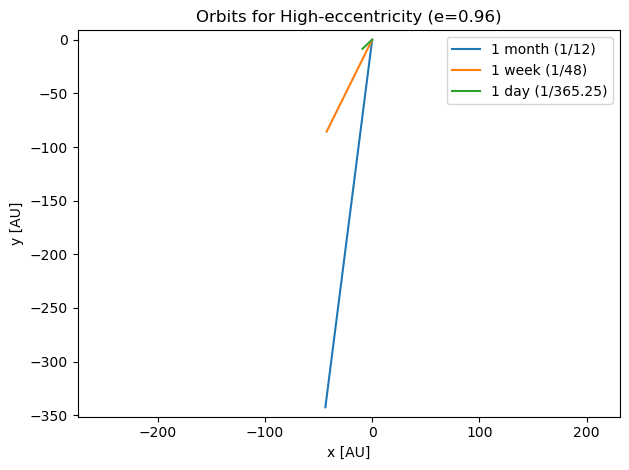

,eccentricity,timestep,dt [yr],position error [AU],energy error [AU^2/yr^2]
0,0.00,1 month (1/12),0.083333,0.043877,-1.491946e-01
1,0.00,1 week (1/48),0.020833,0.000074,-1.328730e-04
2,0.00,1 day (1/365.25),0.002738,0.004301,-5.186575e-09
3,0.96,1 month (1/12),0.083333,345.464738,5.969164e+04
4,0.96,1 week (1/48),0.020833,95.529356,4.579994e+03
5,0.96,1 day (1/365.25),0.002738,12.280171,8.270122e+01


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Constants
GM = 4 * np.pi**2  # AU^3 / yr^2

def kepler_derivs(state):
    x, y, vx, vy = state
    r = np.hypot(x, y)
    ax = -GM * x / r**3
    ay = -GM * y / r**3
    return np.array([vx, vy, ax, ay])

def rk4_step(f, state, dt):
    k1 = f(state)
    k2 = f(state + 0.5 * dt * k1)
    k3 = f(state + 0.5 * dt * k2)
    k4 = f(state + dt * k3)
    return state + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

def integrate(ecc, dt, t_final=1.0):
    """
    Integrate one full period t_final using RK4 with fixed dt, starting at pericenter.
    Returns (xs, ys, pos_error, energy_error).
    """
    # number of steps to hit t_final exactly
    n_steps = int(np.round(t_final / dt))
    a = 1.0
    rp = a * (1 - ecc)
    vp = np.sqrt(GM / a) * np.sqrt((1 + ecc) / (1 - ecc))
    # initial state: at (0, rp), velocity (-vp, 0)
    state = np.array([0.0, rp, -vp, 0.0])
    xs, ys = [state[0]], [state[1]]
    initial_state = state.copy()
    
    for _ in range(n_steps):
        state = rk4_step(kepler_derivs, state, dt)
        xs.append(state[0])
        ys.append(state[1])
    
    # compute error at t_final
    pos_error = np.linalg.norm(state[:2] - initial_state[:2])
    v = state[2:]
    r = np.hypot(*state[:2])
    energy = 0.5 * np.dot(v, v) - GM / r
    v0 = initial_state[2:]
    r0 = np.hypot(*initial_state[:2])
    E0 = 0.5 * np.dot(v0, v0) - GM / r0
    energy_error = energy - E0
    
    return np.array(xs), np.array(ys), pos_error, energy_error

# Parameters
dt_list = [1/12, 1/48, 1/365.25]
labels = ['1 month (1/12)', '1 week (1/48)', '1 day (1/365.25)']
ecc_values = [0.0, 0.96]

# Build error table
results = []
for ecc in ecc_values:
    for dt, label in zip(dt_list, labels):
        _, _, pos_err, e_err = integrate(ecc, dt)
        results.append({
            'eccentricity': ecc,
            'timestep': label,
            'dt [yr]': dt,
            'position error [AU]': pos_err,
            'energy error [AU^2/yr^2]': e_err
        })
df = pd.DataFrame(results)

# Plot orbits
for ecc, title in zip(ecc_values, ['Circular (e=0)', 'High-eccentricity (e=0.96)']):
    plt.figure()
    for dt, label in zip(dt_list, labels):
        xs, ys, _, _ = integrate(ecc, dt)
        plt.plot(xs, ys, label=label)
    plt.xlabel('x [AU]')
    plt.ylabel('y [AU]')
    plt.title(f'Orbits for {title}')
    plt.axis('equal')
    plt.legend()
    plt.tight_layout()
    plt.show()
df

This worked! At least I think so... This is a somewhat reasonable result, though it is different than what I got when I did the problem myself. However, I am not sure if this is correct or mine is, as the results are similar enough, and I cannot find the mistake in this code...

### Hogg and Foreman-Mackey Problem 2

This one was by far the easiest of the tasks. All I did was input a screenshot of the problem into Gemini 2.5 Pro, and say "solve this problem in python". It spit the following code out first try.

Running M-H MCMC for 50000 steps...
Sampling complete.
Removed 5000 burn-in samples. Using 45000 samples for analysis.
Target Distribution: Mean=2.0, StdDev=1.4142
Sample Statistics: Mean=1.9725, StdDev=1.4318


(-4.518421798426319, 7.919260401166612)

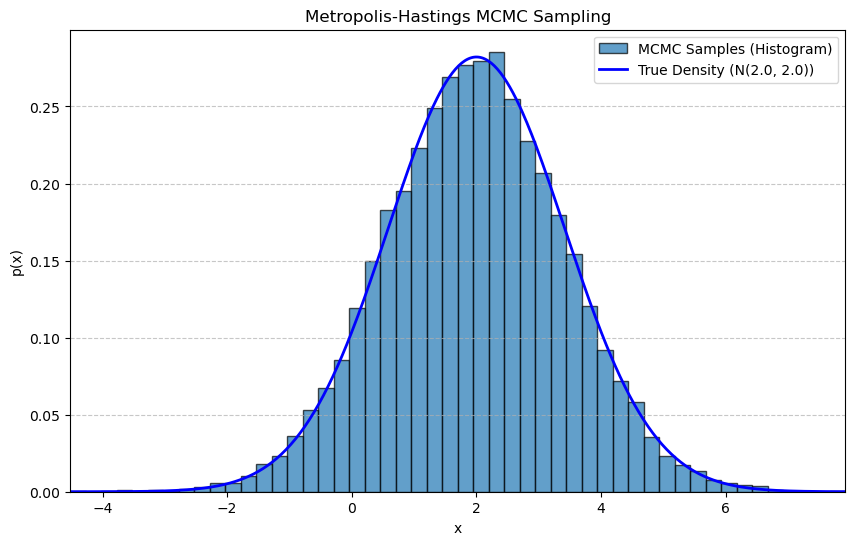

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- Parameters ---

# Target distribution: Gaussian N(mean, variance)
target_mean = 2.0
target_variance = 2.0
target_std_dev = np.sqrt(target_variance)

# Proposal distribution: Gaussian N(x_current, proposal_variance)
proposal_variance = 1.0
proposal_std_dev = np.sqrt(proposal_variance)

# MCMC parameters
n_steps = 50000      # Total number of steps (choose > 10000)
burn_in = 5000       # Number of initial steps to discard (optional but good practice)
initial_value = 0.0  # Starting point for the sampler

# --- Target PDF ---

def target_pdf(x):
  """
  Calculates the probability density of the target Gaussian distribution.
  Target: N(mean=2, variance=2)
  """
  return norm.pdf(x, loc=target_mean, scale=target_std_dev)

# --- Metropolis-Hastings Sampler ---

samples = []
x_current = initial_value

print(f"Running M-H MCMC for {n_steps} steps...")

for i in range(n_steps):
  # 1. Propose a new state (x_proposal) based on the current state (x_current)
  # Proposal distribution q(x'|x) is N(x, proposal_variance=1)
  x_proposal = np.random.normal(loc=x_current, scale=proposal_std_dev)

  # 2. Calculate the acceptance probability (alpha)
  # alpha = min(1, [p(x_proposal) * q(x_current|x_proposal)] / [p(x_current) * q(x_proposal|x_current)])
  # Since the proposal distribution N(x, 1) is symmetric, q(x'|x) = q(x|x').
  # The q terms cancel out, simplifying to:
  # alpha = min(1, p(x_proposal) / p(x_current))

  p_proposal = target_pdf(x_proposal)
  p_current = target_pdf(x_current)

  # Avoid division by zero if p_current is extremely small (though unlikely for Gaussian)
  if p_current == 0:
      acceptance_ratio = 1.0 # If current is impossible, always accept a possible proposal
  else:
      acceptance_ratio = p_proposal / p_current

  alpha = min(1.0, acceptance_ratio)

  # 3. Accept or reject the proposal
  u = np.random.rand() # Draw a random number from Uniform(0, 1)
  if u < alpha:
    x_current = x_proposal # Accept the proposal

  # 4. Store the current state (it's x_current whether accepted or rejected)
  samples.append(x_current)

print("Sampling complete.")

# --- Post-processing and Plotting ---

# Discard the burn-in samples
samples_after_burn_in = np.array(samples[burn_in:])

print(f"Removed {burn_in} burn-in samples. Using {len(samples_after_burn_in)} samples for analysis.")

# Calculate sample statistics (optional comparison)
sample_mean = np.mean(samples_after_burn_in)
sample_std_dev = np.std(samples_after_burn_in)
print(f"Target Distribution: Mean={target_mean}, StdDev={target_std_dev:.4f}")
print(f"Sample Statistics: Mean={sample_mean:.4f}, StdDev={sample_std_dev:.4f}")


# Plot the results
plt.figure(figsize=(10, 6))

# Histogram of the samples (normalized to form a probability density)
count, bins, ignored = plt.hist(samples_after_burn_in, bins=50, density=True, alpha=0.7,
                                label='MCMC Samples (Histogram)', edgecolor='black')

# Plot the true target probability density function
x_range = np.linspace(bins[0], bins[-1], 500) # Use histogram range for plotting PDF
true_density = target_pdf(x_range)
plt.plot(x_range, true_density, 'b-', linewidth=2, label=f'True Density (N({target_mean}, {target_variance}))')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('p(x)')
plt.title('Metropolis-Hastings MCMC Sampling')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(bottom=0) # Ensure y-axis starts at 0

# Try to make plot appearance similar to Figure 1
plt.xlim(min(x_range), max(x_range)) # Auto-adjust x-limits based on data/PDF plot range
# Or set manually

### Discussion

For the first problem, I exhausted all of my free attempts on all the LLMs I used that day. I had to give a large amount of guidance in order to get anything that worked at all without large bugs, but even then, the solution was incomplete. I think this is because the large amount of reasoning and steps required, along with the fact that this is a relatively niche piece of code. The training set likely does not contain extremely numerous examples of Hernquist density profile sampling codes.

For the second problem, I pretty quickly got a working piece of code, which implemented something reasonable looking. However, I dont believe the solution is correct, despite me not being able to find the exact mistake being made. Because I know what the solution should look like, I can tell something is wrong, but in a case in which I could'nt tell, this is very insidious. I think this is an extremely good example of what people are learning over the past few months about using AI to code; if you already know the subject quite well, it can be helpful and you can catch mistakes on the fly. Otherwise, mistakes and errors and misunderstandings can accrue at an alarming rate, despite things being fine at first glance (no major bugs, no errors thrown, etc). This gray area is also the most active area of AI research, where AI labs are working to try and get these computers to be so good that they really can become reliable tools for more complex coding tasks. The technology is not yet here.

The last task was by far the easiest. It took the most naive prompt, and a single try, to get the desired outcome. This is probably because the task is quite well documented, being a simple implementation of one of the most famous algorithms in scientific computing. I also think the thorough and accurate description of the problem by Hogg and Foreman-Mackey was helpful in this case.

Overall, AI cannot really replace me completely for homework tasks. I think its best use is at a smaller scale. Rather than trying to build whole pipelines or large solutions all at once, I have found they can be relied upon to solve smaller scale problems within a larger project, such as writing a for loop, or debugging a function. The problems it is best at are well known, simple problems. This means that using AI for something that you know how to do but will take time, or for something slightly out of your expertise but you know is very simple and done often, is probably the most effective. Not only is it more likely to work with less sophisticated prompting techniques and less tries, but it will also be easy to check or debug considering the task is so well known.

### Periodic Boundary Conditions

In [56]:
import numpy as np
import time
import numba

In [60]:
# Generate positions
@numba.jit(nopython=True)
def generate_positions(N, seed=2066):
    np.random.seed(seed)
    return np.random.uniform(0, 100, (N, 3))

# Direct acceleration calculator
@numba.jit(nopython=True)
def acceleration_direct(positions, G=1.0, m=1.0, softening=1e-9):
    N = positions.shape[0]
    acc = np.zeros((N, 3))

    for i in range(N):
        for j in range(N):
            if i != j:
                dx = positions[j, 0] - positions[i, 0]
                dy = positions[j, 1] - positions[i, 1]
                dz = positions[j, 2] - positions[i, 2]

                r2 = dx * dx + dy * dy + dz * dz + softening * softening
                r3 = r2 * np.sqrt(r2)

                acc[i, 0] += G * m * dx / r3
                acc[i, 1] += G * m * dy / r3
                acc[i, 2] += G * m * dz / r3

    return acc


In [62]:
# Direct acceleration calculator
@numba.jit(nopython=True)
def acceleration_direct(positions, G=1.0, m=1.0, softening=1e-9):
    N = positions.shape[0]
    acc = np.zeros((N, 3))

    for i in range(N):
        for j in range(N):
            if i != j:
                dx = positions[j, 0] - positions[i, 0]
                dy = positions[j, 1] - positions[i, 1]
                dz = positions[j, 2] - positions[i, 2]

                r2 = dx * dx + dy * dy + dz * dz + softening * softening
                r3 = r2 * np.sqrt(r2)

                # Apply periodic boundary conditions using minimum image convention
                dx -= L * np.round(dx / L)
                dy -= L * np.round(dy / L)
                dz -= L * np.round(dz / L)

                acc[i, 0] += G * m * dx / r3
                acc[i, 1] += G * m * dy / r3
                acc[i, 2] += G * m * dz / r3

    return acc


In [58]:
N = 10**5

In [61]:
positions = generate_positions(N)
start = time.time()
accel = acceleration_direct(positions)
end = time.time()
print(f"N={N}: Time = {end - start:.4f} seconds")

N=100000: Time = 60.3829 seconds


In [64]:
positions_pbc = generate_positions(10**5)
start = time.time()
accel_pbc = acceleration_direct_pbc(positions)
end = time.time()
print(f"N={N}: Time = {end - start:.4f} seconds")

N=100000: Time = 106.4125 seconds


The only change required was to include the minimum image convention, which just wraps the box into a toroidal geometry. The timing is clearly slightly worse for a PBC scenario, which makes sense many points on the edges now have more neighbors to concider. 

The way to do this with KDTrees depends on the implementation. In my case, in the original solution I wrote for HW3, I used scipy.spatial.cKDTree. This has a method known as "boxsize", which allows for the optional use of PBC's. Presumably, the way to adjust the KDTrees algorithm is just to check for distances with a modified distance function, which takes into account the PBC's changes to the distances between points. Then the KDTree algorithm itself will not have to be changed, but should just accomodate the new distance function.